In [74]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [75]:
df_weather = pd.read_parquet('../../data/weather_hourly_philadelphia_cleaned.parquet')
df_weather.head()

,max_temp,min_temp,precip
date_time,,,
2016-01-01 00:00:00,6.7,6.7,0.0
2016-01-01 01:00:00,7.2,7.2,0.0
2016-01-01 02:00:00,6.7,6.7,0.0
2016-01-01 03:00:00,6.7,6.7,0.0
2016-01-01 04:00:00,6.1,6.1,0.0


In [76]:

yp = df_weather["min_temp"].values

xp = df_weather["max_temp"].values


Text(0, 0.5, 'demand')

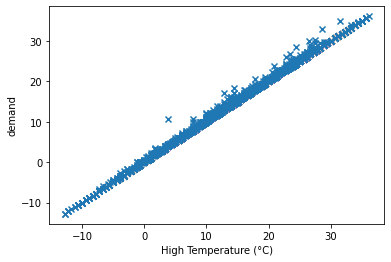

In [77]:
plt.scatter(yp, xp, marker='x')
plt.xlabel("High Temperature (°C)")
plt.ylabel("demand")

#Macht keinen Sinn...

In [78]:
df_stations = pd.read_parquet('../../data/stations.parquet')
df_stations.head()

,lat,lon,name,id
0,39.962380,-75.161712,"Spring Garden Station, BSL, Philadelphia, PA",3059
1,39.942987,-75.160208,"11th & South, Philadelphia, PA",3101
2,39.979946,-75.155375,"13th & Montgomery, Philadelphia, PA",3031
3,39.941168,-75.145552,"2nd & South, Philadelphia, PA",3026
4,39.956799,-75.182270,"Amtrak 30th Street Station, Philadelphia, PA",3022


# To-Do: Mapping the stations to see where they are located


In [79]:
philadelphia_map = folium.Map(
    location=(39.952583, -75.165222),  # the orig mean values as location coordinates from https://www.latlong.net/place/philadelphia-pa-usa-18557.html
    zoom_start=12,
    control_scale=True,
    max_zoom=20,
)

for _, row in df_stations.iterrows():
    folium.Marker(
        location=[row["lat"], row["lon"]],
        popup=row["id"],
        icon=folium.Icon(color="red"),
    ).add_to(philadelphia_map)


philadelphia_map

It can be seen that the stations are concentrated in a certain area, probably the center area of Philadelphia. Only one station is more of an outlier to the other stations, but it is still in Philadelphia.

# Feature Engineering


In [111]:
df_bike_trips = pd.read_parquet('../../data/bike_trips_cleaned.parquet')
df_bike_trips.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,start_lon,end_lat,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip
index,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,-75.143749,39.969241,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01 00:00:00,6.7,6.7,0.0
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,-75.149370,39.954694,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01 00:00:00,6.7,6.7,0.0
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,-75.159952,39.945664,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01 00:00:00,6.7,6.7,0.0
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,-75.162361,39.940735,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,2016-01-01 00:00:00,6.7,6.7,0.0
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,-75.144145,39.938280,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,2016-01-01 01:00:00,7.2,7.2,0.0


## Creating new relevant features
In order to get better prediction results, we create new features from the existing ones to make them more fit to our goal. 

As seen in *temporal_demand_patterns_and_seasonality* a higher fleet usage can be seen during business days. So one of the features that can be added is *is_weekday*, which is a binary feature, where 0 represents that it is the weekend and 1 that it is a weekday. 

In [112]:
# Add column with weekdays to dataset: as for now weekday name, but want it to be binary (0 / 1)
df_bike_trips['is_weekday'] = df_bike_trips['date_time'].dt.day_name()

#tried to write a method that turns the weekday id's (0-6) to binary (0/1)
#def is_weekday_binary(x:pd.DataFrame):
#    if df_bike_trips['date_time'].dt.weekday() <=5:
#        df_bike_trips['is_weekday'] = 1
#    else:
#        df_bike_trips['is_weekday'] = 0
        
#df_bike_trips['is_weekday'] = is_weekday_binary(df_bike_trips['date_time'])

df_bike_trips.head()



,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,...,end_lat,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip,is_weekday
index,,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,...,39.969241,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01 00:00:00,6.7,6.7,0.0,Friday
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,...,39.954694,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01 00:00:00,6.7,6.7,0.0,Friday
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,...,39.945664,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01 00:00:00,6.7,6.7,0.0,Friday
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,...,39.940735,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,2016-01-01 00:00:00,6.7,6.7,0.0,Friday
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,...,39.938280,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,2016-01-01 01:00:00,7.2,7.2,0.0,Friday


## Looking at correlation of all features

A correlation vslue between 0.7 and 1 indicate a strong positive linear relationship. A negative strong relationship is indicated by values between -0.7 and -1.  

In [81]:
df_bike_trips.corr()

,start_station_id,end_station_id,bike_id,start_lat,start_lon,end_lat,end_lon,distance,speed,max_temp,min_temp,precip
start_station_id,1.000000,0.108260,0.029191,0.168951,0.034936,0.114612,0.014730,-0.005325,-0.070398,0.034446,0.034569,-0.013400
end_station_id,0.108260,1.000000,0.027920,0.108410,0.013715,0.147627,0.043566,-0.006463,-0.076653,0.096196,0.096276,-0.013490
bike_id,0.029191,0.027920,1.000000,0.008699,-0.001899,0.011772,-0.008437,0.009743,0.012064,0.043625,0.043689,-0.004298
start_lat,0.168951,0.108410,0.008699,1.000000,-0.049300,0.429814,-0.032436,0.061059,-0.008583,0.030342,0.030223,-0.002144
start_lon,0.034936,0.013715,-0.001899,-0.049300,1.000000,-0.027057,0.428520,-0.113146,-0.165863,0.005061,0.005115,-0.007149
end_lat,0.114612,0.147627,0.011772,0.429814,-0.027057,1.000000,-0.056419,0.044056,-0.016130,0.001508,0.001520,-0.002518
end_lon,0.014730,0.043566,-0.008437,-0.032436,0.428520,-0.056419,1.000000,-0.052775,-0.105229,0.017920,0.017852,-0.006493
distance,-0.005325,-0.006463,0.009743,0.061059,-0.113146,0.044056,-0.052775,1.000000,0.627001,0.003488,0.003612,-0.003764
speed,-0.070398,-0.076653,0.012064,-0.008583,-0.165863,-0.016130,-0.105229,0.627001,1.000000,-0.054129,-0.054044,0.015708
max_temp,0.034446,0.096196,0.043625,0.030342,0.005061,0.001508,0.017920,0.003488,-0.054129,1.000000,0.999563,-0.087740


**Following the features with correlations higher than 0.7 or lower -0.7 will be shown.**

In [82]:
# High correlations: 0.7-1.0 and (-0.7)-(-1.0)

def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(df_bike_trips, .7)

max_temp          min_temp            0.999563
start_station_id  start_station_id         NaN
dtype: float64

It can be seen that only max_temp and min_temp have a high correlation. So either of the two can be eliminated,because with highly correlated features one can be predicted from another. (Not quite sure why start_station_id is shown)

**The features with a high correaltion (positive or negative) can also be shown graphically for an easier overview**

<AxesSubplot:>

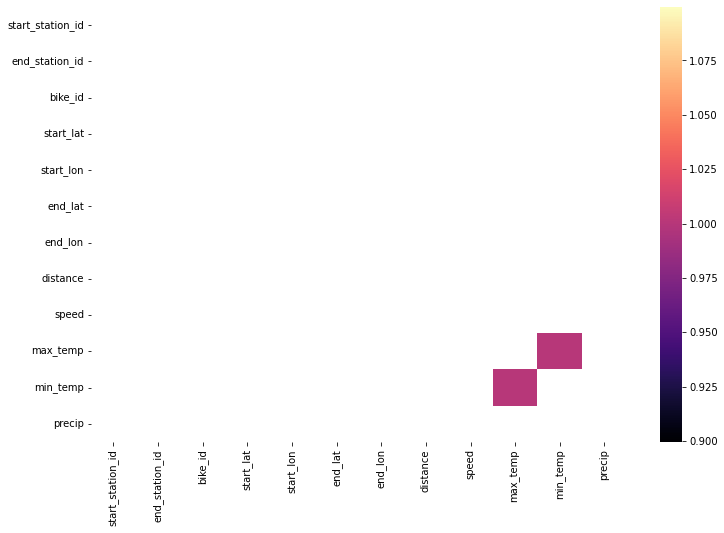

In [83]:
# Correlation highlighter

corr = df_bike_trips.corr()

#kot = corr[((corr>=.7) or (corr<=-.7))]
kot = corr[((corr >= .7) | (corr <= -.7)) & (corr !=1.000)]
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="magma")

In [84]:
#Tried another method to show high correlations, but only one of the pairs are shown. 
#Could be irrelevant, as one of the features have to be dropped anyway, but it would be nicer to show the relationship.

# Showing high correlations: 0.7-1.0 and (-0.7)-(-1.0)


correlated_features = set()
correlation_matrix = df_bike_trips.corr()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if (abs(correlation_matrix.iloc[i, j]) > 0.7) or (abs(correlation_matrix.iloc[i, j]) < -0.7):
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

            


In [85]:
len(correlated_features)

1

In [86]:
print(correlated_features)

#Not sure why only one feature is shown and not the corrseponfing one too...

{'min_temp'}


It can be seen that only one feature has a high positive correlation min_temp with max_temp.

## Idea
Features that could be used: duration, distance, rainy, season, weekday, temp, start and end stations
In general different weather conditions like:
1: Clear, Few clouds, Partly cloudy, Partly cloudy

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

=> Integrate that either in one parquet or use the feature engineering code for all the regression analysis 

Idea: Linear regression using LASSO regularization to look, if the features are important
From Lec.: "This type of regularization (L1) can lead to zero coefficients of particular features so LASSO also helps in feature selection"

## Dropping unrelevant features
In our dataset we have features that are not important for our prediction, so we are dropping them. Others where created from features from our dataset, so they are not relevant individually.

In [91]:
#WANT TO DROP UNIMPORTANT FEATURES AND CREATE NEW ONES TO TEST THEM LATER
#As of now dropping value with high correlation and intuitively what could maybe be dropped - just a suggestion for now

columnsToDrop = ['start_time', 'end_time', 'end_station_name', 'start_station_name', 'bike_id', 'user_type', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'max_temp']


df_bike_trips.drop(columnsToDrop, axis=1, inplace=True)




In [92]:
df_bike_trips.head()

,start_station_id,end_station_id,duration,distance,speed,average_time,date_time,min_temp,precip
index,,,,,,,,,
0,3046,3041,0 days 00:10:00,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01 00:00:00,6.7,0.0
1,3028,3019,0 days 00:22:00,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01 00:00:00,6.7,0.0
2,3007,3066,0 days 00:13:00,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01 00:00:00,6.7,0.0
3,3045,3028,0 days 00:10:00,1.458133,8.748797,2016-01-01 00:25:00,2016-01-01 00:00:00,6.7,0.0
4,3005,3064,0 days 00:22:00,3.313616,9.037136,2016-01-01 00:31:00,2016-01-01 01:00:00,7.2,0.0


## Feature correlation

Again a feature correlation overview with the remaining features

In [89]:
df_bike_trips.corr()

,distance,speed,max_temp,min_temp,precip
distance,1.000000,0.627001,0.003488,0.003612,-0.003764
speed,0.627001,1.000000,-0.054129,-0.054044,0.015708
max_temp,0.003488,-0.054129,1.000000,0.999563,-0.087740
min_temp,0.003612,-0.054044,0.999563,1.000000,-0.094389
precip,-0.003764,0.015708,-0.087740,-0.094389,1.000000
